## Execution Auction Simulation – Data Visualization

This notebook is designed to analyze simulation results from the execution auction model.
All configuration and logic is defined outside this notebook, in the following files:
- main.py

- player.py

- auction.py

- player_setup.py

This data visualization notebook performs:
- Extraction of round-by-round simulation data

- Flattening results into a player-round DataFrame

- Visualization and analysis of the data

The goal is to examine whether submission time or player type affects winning or profit outcomes in the sealed-bid  first price auction setting.

### 1. Run Simulation and Extract Results
**Note: Simulation parameters live in external modules. We execute main.py directly to inherit its configuration.**

In [30]:
import runpy
from auction import Auction
from player import Player
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Execute main.py to use its internal config and run simulation
main_ns = runpy.run_module("main", run_name="__main__")
players       = main_ns["players"]
round_results = main_ns.get("round_results") or main_ns.get("round_results", main_ns.get("round_results"))
winnings      = main_ns["winnings"]
print(f"Imported simulation: {len(round_results):,} rounds, {len(players)} players")

# Flatten results into one row per player per round
rows = []
for rnd, rd in enumerate(round_results):
    cutoff = rd["cutoff_time"]
    winner_id, winning_bid, winning_profit = rd["winner"] or (None, None, 0.0)

    for p in players:
        submit_time = rd["submit_bys"][p.player_id]
        valuation = rd["valuations"][p.player_id]
        bid_amount = None  # default if not found
        for player_obj, bid in rd["actions"]:
            if player_obj.player_id == p.player_id:
                bid_amount = bid
                break  # stop the loop once we find the match

        rows.append({
            "round":        rnd,
            "player_id":    p.player_id,
            "reactive":     p.reactive,
            "submit_time":  submit_time,
            "cutoff_time":  cutoff,
            "valuation":    valuation,
            "bid_amount":   bid_amount,
            "won":          int(p.player_id == winner_id),
            "profit":       winning_profit if p.player_id == winner_id else 0.0
        })

# Create DataFrame
df = pd.DataFrame(rows)
print(df.shape)
df.head()


===== First 5 Round(s) Details ======

--- Round 1 --- Cutoff Time: 0.6723
Winner: P1 (Non-Reactive) | Bid: 0.7820 | Profit: 0.0000
ID   Type           Valuation  Bid        Submit Time   Status
------------------------------------------------------------
P0   Non-Reactive   0.4079     0.4079     0.1560        ON TIME
P1   Non-Reactive   0.7820     0.7820     0.2283        ON TIME
P2   Non-Reactive   0.7000     0.6312     0.0738        ON TIME
P3   Non-Reactive   0.2303     0.2034     0.1893        ON TIME
P4   Non-Reactive   0.5674     0.3353     0.1380        ON TIME
P5   Reactive       0.7371     0.7371     0.6122        ON TIME
P6   Reactive       0.2576     0.2576     0.4108        ON TIME
P7   Reactive       0.6447     0.6447     0.4099        ON TIME
P8   Reactive       0.3250     0.3250     0.4381        ON TIME
P9   Reactive       0.5033     0.5033     0.4886        ON TIME

--- Round 2 --- Cutoff Time: 0.6456
Winner: P6 (Reactive) | Bid: 0.7114 | Profit: 0.1710
ID   Type    

,round,player_id,reactive,submit_time,cutoff_time,valuation,bid_amount,won,profit
0,0,0,False,0.156036,0.67229,0.407930,0.407926,0,0.000000
1,0,1,False,0.228336,0.67229,0.782001,0.781994,1,0.000008
2,0,2,False,0.073806,0.67229,0.700046,0.631244,0,0.000000
3,0,3,False,0.189264,0.67229,0.230259,0.203353,0,0.000000
4,0,4,False,0.137999,0.67229,0.567448,0.335338,0,0.000000


#### Save Results to CSV (Optional) Save Results to CSV

In [31]:
# Uncomment to save results for later use
# df.to_csv("auction_rounds.csv", index=False)
# print("Exported to auction_rounds.csv")

#### Check sanity counts

In [32]:
print("\nUnique players :", df['player_id'].nunique())
print("Reactive count :", df['reactive'].sum())
print("Non-reactive   :", (~df['reactive']).sum())
print("Rounds covered :", df['round'].nunique())
print("Bid amount :", df['bid_amount'].describe())

# Missing values check
print("\nNull values per column:")
print(df.isna().sum())


Unique players : 10
Reactive count : 1080000
Non-reactive   : 1080000
Rounds covered : 216000
Bid amount : count    2.160000e+06
mean     4.523601e-01
std      2.671597e-01
min      7.342442e-07
25%      2.230076e-01
50%      4.455315e-01
75%      6.726693e-01
max      9.999899e-01
Name: bid_amount, dtype: float64

Null values per column:
round          0
player_id      0
reactive       0
submit_time    0
cutoff_time    0
valuation      0
bid_amount     0
won            0
profit         0
dtype: int64


### 2. Submit-Time Distribution by Player Type

Purpose: Check whether reactive players really submit later, and if the timing separation works as intended.

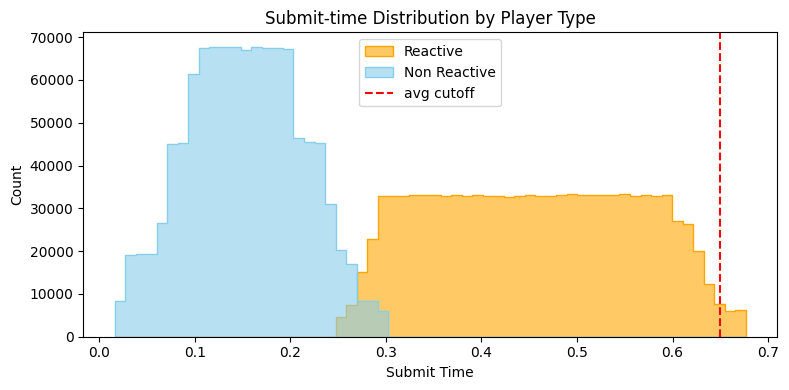

In [33]:
# Submit-time histogram, split by type
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x='submit_time',
    hue='reactive',
    bins=60,
    palette=['skyblue','orange'],
    alpha=0.6,
    element='step'
)
plt.axvline(df['cutoff_time'].mean(), ls='--', color='red', label='avg cutoff')
plt.title('Submit-time Distribution by Player Type')
plt.xlabel('Submit Time')
plt.ylabel('Count')
plt.legend(labels=["Reactive", "Non Reactive", "avg cutoff",])
plt.tight_layout()
plt.show()

### 3. Overall Win Rate vs Submit-Time Quartile

Purpose: Assess whether later bid submissions correlate with higher likelihood of winning, regardless of player type.

C:\Users\hyojo\AppData\Local\Temp\ipykernel_27952\630737638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate = df.groupby('time_q')['won'].mean()


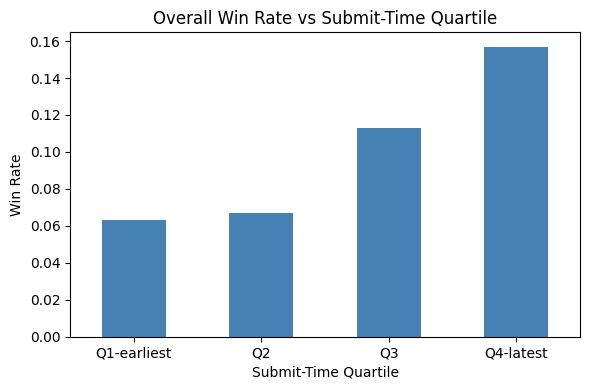

In [34]:
df['time_q'] = pd.qcut(
    df['submit_time'], 4,
    labels=["Q1-earliest","Q2","Q3","Q4-latest"])
win_rate = df.groupby('time_q')['won'].mean()

plt.figure(figsize=(6,4))
win_rate.plot(
    kind='bar',
    color='steelblue')

plt.title('Overall Win Rate vs Submit-Time Quartile')
plt.xticks(rotation=0)
plt.xlabel('Submit-Time Quartile')
plt.ylabel('Win Rate')
plt.tight_layout()
plt.show()

Summary: The bar chart reveals whether win probability increases in later quartiles. A flat or declining trend would indicate that timing alone does not confer a competitive edge.

### 4. Win Rate by Submit-Time Quartile and Player Type
Purpose: Determine if the impact of submission timing on win probability differs between reactive and un-reactive players.

C:\Users\hyojo\AppData\Local\Temp\ipykernel_27952\2728040665.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['time_q','reactive'])['won']


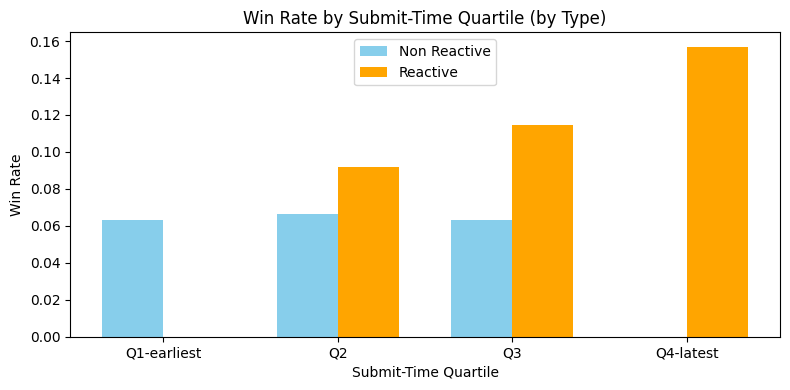

In [35]:
import numpy as np
import matplotlib.pyplot as plt

split_win = (
    df.groupby(['time_q','reactive'])['won']
      .mean()
      .reset_index()
      .pivot(index='time_q', columns='reactive', values='won')
      .rename(columns={False:'Un-reactive', True:'Reactive'})
)

x = np.arange(len(split_win))
width = 0.35
plt.figure(figsize=(8,4))
plt.bar(x - width/2, split_win['Un-reactive'], width,
        label='Non Reactive', color='skyblue')
plt.bar(x + width/2, split_win['Reactive'],   width,
        label='Reactive',   color='orange')
plt.xticks(x, split_win.index)
plt.title('Win Rate by Submit-Time Quartile (by Type)')
plt.xlabel('Submit-Time Quartile')
plt.ylabel('Win Rate')
plt.legend()
plt.tight_layout()
plt.show()

Summary: Comparing within-type bars shows if reactive players still win more often from later submissions, and whether un-reactive players ever benefit from timing. Diverging slopes indicate type-specific timing effects.

### 5. Total and Average Profit by Player Type
Purpose: Compare aggregate earnings to determine which player type achieves greater economic benefit over all rounds.

In [36]:
# Total profit grouped by player type
print("Total Profit by Type:")
print(
    df.groupby('reactive')['profit'].sum()
      .rename({False:'Un-reactive', True:'Reactive'})
)

# Average profit per player in each type
print("\nAverage Profit per Player:")
avg_profit = (
    df.groupby(['player_id','reactive'])['profit'].sum()
      .reset_index()
      .groupby('reactive')['profit'].mean()
      .rename({False:'Un-reactive', True:'Reactive'})
)
print(avg_profit)

Total Profit by Type:
reactive
Un-reactive     2284.453578
Reactive       10194.642992
Name: profit, dtype: float64

Average Profit per Player:
reactive
Un-reactive     456.890716
Reactive       2038.928598
Name: profit, dtype: float64


Summary: These summary quantify whether one group outperforms the other in total and per-player profit, indicating if timing or strategy yields greater economic advantage.

### 6. Profit per Win by Submit-Time Quartile and Player Type
Purpose: Evaluate whether winners who submit later secure higher profit margins, and whether this differs by player type.

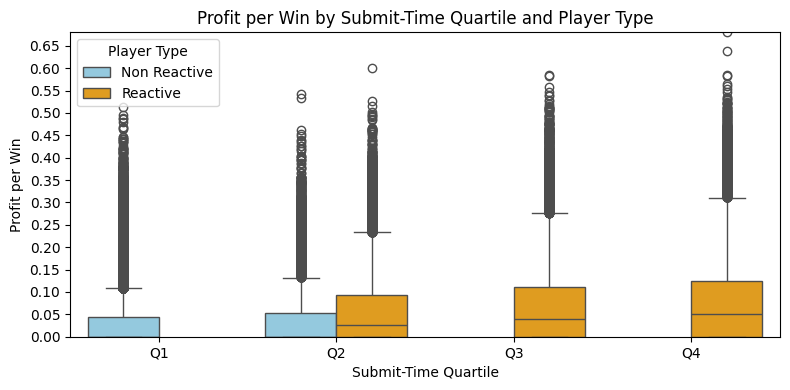

In [37]:
winners = df[df['won']==1].copy()
winners['quartile'] = pd.qcut(
    winners['submit_time'], 4,
    labels=["Q1","Q2","Q3","Q4"]
)
winners['type'] = winners['reactive'].map({True:'Reactive', False:'Non Reactive'})

plt.figure(figsize=(8,4))
sns.boxplot(
    data=winners,
    x='quartile',
    y='profit',
    hue='type',
    palette={'Non Reactive': 'skyblue', 'Reactive': 'orange'}
)
plt.title('Profit per Win by Submit-Time Quartile and Player Type')
plt.xlabel('Submit-Time Quartile')
plt.ylabel('Profit per Win')
plt.legend(title='Player Type')
plt.ylim(0, winners['profit'].max())
plt.yticks(np.arange(0, winners['profit'].max(), 0.05))
plt.tight_layout()
plt.show()

C:\Users\hyojo\AppData\Local\Temp\ipykernel_27952\3154140182.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_profit_by_type, x='type', y='profit', palette=['skyblue', 'orange'])


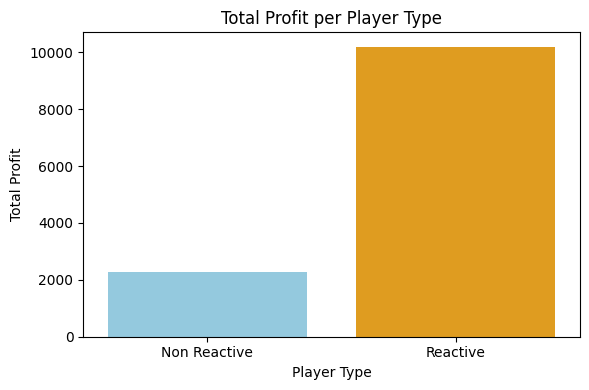

In [38]:
# Map player type from 'reactive' boolean
df['type'] = df['reactive'].map({True: 'Reactive', False: 'Non Reactive'})

# Group and sum total profit by player type
total_profit_by_type = df.groupby('type')['profit'].sum().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=total_profit_by_type, x='type', y='profit', palette=['skyblue', 'orange'])
plt.title('Total Profit per Player Type')
plt.xlabel('Player Type')
plt.ylabel('Total Profit')
plt.tight_layout()
plt.show()